**Проектная работа по детекции объектов**

В качестве предобученной модели выбрана FasterRCNN_Resnet50

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Загружаем модель предобученную на датасете COCO

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
model_torch = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


**Теперь попробуем модель в действии:**
По выбранной картинке сделаем детекцию объектов, для этого загрузим необходимые бибилиотеки и сначала прост посмотрим на изображение

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def img_show(img_path):
  img = cv2.imread(img_path)[:,:,::-1]
  fig = plt.figure(figsize=(10,5))
  plt.imshow(img);

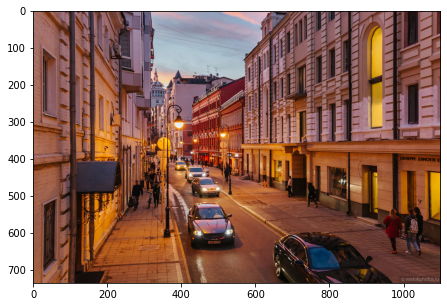

In [6]:
img_show('/content/street.jpg')

**Делаем предсказание**
для этого переводим модель в режим eval и подаем изображение преобразованное в тензор

In [7]:
img_path = '/content/street.jpg'
model_torch = model_torch.eval()
img_numpy = cv2.imread(img_path)[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1) / 255.
print(img.shape)

predictions = model_torch(img[None,...].to(device))

torch.Size([3, 734, 1100])


Напишем функцию для отрисовки предсказанных боксов и ограничение по вероятности предсказанных классов не менее 50%. Так же подпишем полученные значения на картинке

In [5]:
def plot_preds(numpy_img, preds):

  CONF_THRESH = 0.7
  boxes = preds['boxes'][preds['scores'] > CONF_THRESH]
  boxes_dict = {}
  boxes_dict['boxes'] = boxes

  labels = preds['labels'].cpu().detach().numpy()
  scores = preds['scores'].cpu().detach().numpy()
  font = cv2.FONT_HERSHEY_SIMPLEX
  for i, box in enumerate(boxes):

    numpy_img = cv2.putText(numpy_img, str(labels[i]), (int(box[0])+5,int(box[1])-5), font, 1, (255,255,0), 2)
    #numpy_img = cv2.putText(numpy_img, str(round(scores[i], 2)), (int(box[0])+5,int(box[1])-45), font, 1, (255,255,0), 2)  

    numpy_img = cv2.rectangle(
        numpy_img, 
        (box[0],box[1]),
        (box[2],box[3]), 
        255,
        3
    )

  return numpy_img.get()

Усовершенствовал предыдущую функцию для отрисовки истинных боксов или предсказанных - на выбор

In [6]:
def plot_img(img_path, model, isboxes = None):

  numpy_img = cv2.imread(img_path)[:,:,::-1]
  img = torch.from_numpy(numpy_img.astype('float32')).permute(2,0,1) / 255.
  font = cv2.FONT_HERSHEY_SIMPLEX

  if isboxes is not None:
      labels = []
      boxes = []
      for item in isboxes:
          labels.append(item[0]) 
          boxes.append([item[1][0], item[1][1], item[2][0], item[2][1]])

  else:
      model = model.eval()
      predictions = model(img[None,...].to(device))
      preds = predictions[0]
      #print(preds)
      
      CONF_THRESH = 0.7
      boxes = preds['boxes'][preds['scores'] > CONF_THRESH]
      boxes_dict = {}
      boxes_dict['boxes'] = boxes

      labels = preds['labels'].cpu().detach().numpy()
      scores = preds['scores'].cpu().detach().numpy()

  for i, box in enumerate(boxes):

    numpy_img = cv2.putText(numpy_img, str(labels[i]), (int(box[0])+5,int(box[1])-5), font, 1, (255,255,0), 2)
    #numpy_img = cv2.putText(numpy_img, str(round(scores[i], 2)), (int(box[0])+5,int(box[1])-45), font, 1, (255,255,0), 2)  

    numpy_img = cv2.rectangle(
        numpy_img, 
        (box[0],box[1]),
        (box[2],box[3]), 
        255,
        3
    )

  if len(boxes) > 0:
      return numpy_img.get()
  else:
      return numpy_img

(734, 1100, 3)


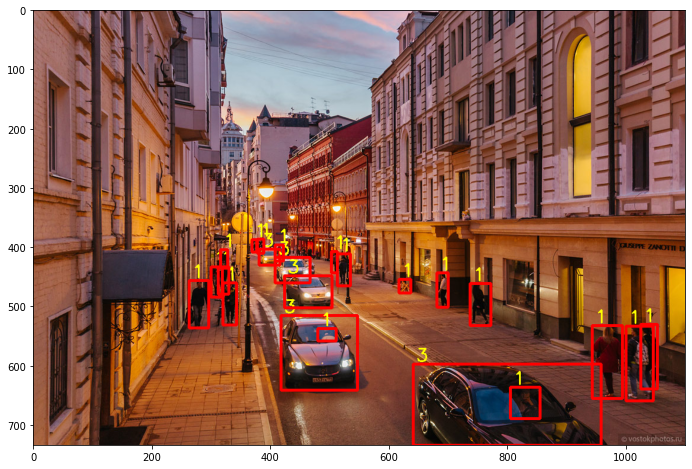

In [10]:
img_with_boxes = plot_preds(img_numpy, predictions[0])
print(img_with_boxes.shape)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

Попробуем еще раз запустить модель на другой картинке

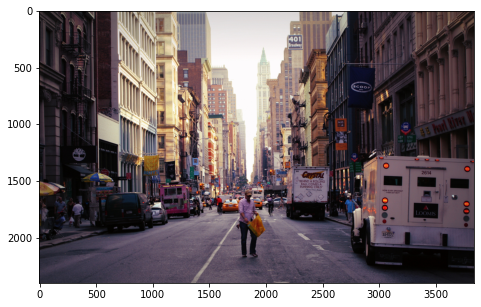

In [11]:
img_show('/content/city.jpg')

torch.Size([3, 2400, 3840])
(2400, 3840, 3)


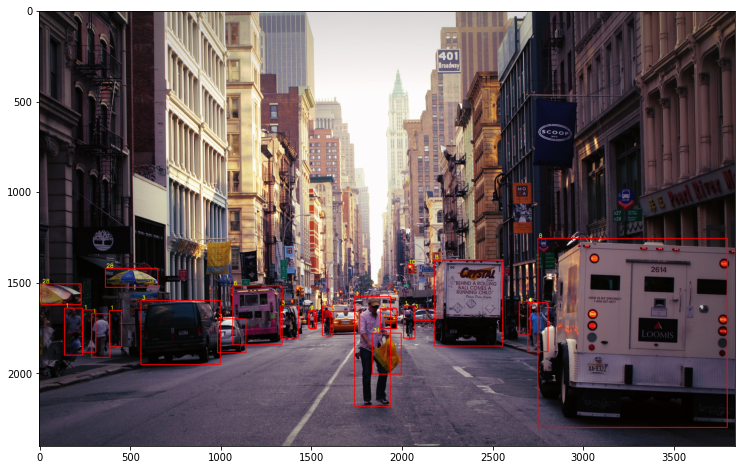

In [15]:
img_path = '/content/city.jpg'
model_torch = model_torch.eval()
img_numpy = cv2.imread(img_path)[:,:,::-1]
img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1) / 255.
print(img.shape)

predictions = model_torch(img[None,...].to(device))

img_with_boxes = plot_preds(img_numpy, predictions[0])
print(img_with_boxes.shape)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

Итак, опробовали предобученную модель. Работает она хорошо, предсказывает разные классы и достаточно хорошо детектирует их на изображениях. Теперь необходимо переучить ее с датасета COCO на новый датасет, чтоб модель детектировала и классифицировала только нужные нам объекты. Для этого я выбрал датасет Kitti object detection. Детектировать будем четыре класса, а именно: машина, автобус, грузовик и велосипедист.
Изначально была задумка сделать детекцию по классификации автомобилей на платных участках дороги для верного определения стоимости проезда. Но там классификация транспортных средств несколько сложнее, которая учитывает высоту автомобилей и количество осей. Я думаю с такими требованиями тоже можно дообучить модель, но нет подходящего датасета, а чтоб сделать его с нуля необходимо достаточное количество времени на сбор данных и ее разметки. Поэтому задача упрощена до имеющегося датасета.
В датасете Kitti object detection используется 9 классов, но, как я указал выше, дообучать модель будем только на детекцию 4-х классов.
Для начала загрузим датасет. Он, кстати, достаточно большой и модель на нем можно вообще обучить с нуля.

Установим связь с Kaggle (чтоб не скачивать датасет локально, а загружать сразу в колаб)

In [7]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 5.3MB 20.9MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 143kB 55.4MB/s 
     |████████████████████████████████| 112kB 56.1MB/s 


In [8]:
import pandas as pd
import os, sys, glob, re
from tqdm import tqdm, tqdm_notebook, tnrange

from torchvision import transforms 

from IPython.display import display, clear_output

In [9]:
#@title Загрузим `kaggle.json` в Colab для доступа в Kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [10]:
#@title Проверяем загруженный файл и готовим для работы с Kaggle
#@markdown + Копируем файл в необходимую директорию
#@markdown + Меняем разрешения доступа к файлу
for fn in uploaded.keys():
  print('Вы загрузили файл "{name}" размером {length} байт'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

Вы загрузили файл "kaggle.json" размером 72 байт
kaggle.json


In [11]:
#@title Проверяем содержимое файла `kaggle.json`

verify_content = True #@param {type: "boolean"}

!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 72 Feb  7 10:33 kaggle.json
{"username":"andreybuynovskiy","key":"b967425e7ee529f2c01250ec682aeff5"}

In [12]:
# Копируем датасет в коллаб (больше 11 Гб)
!kaggle datasets download -d twaldo/kitti-object-detection

100% 11.5G/11.5G [04:37<00:00, 61.2MB/s]
100% 11.5G/11.5G [04:37<00:00, 44.5MB/s]


In [13]:
# Распаковываем датасет
!unzip -q /content/kitti-object-detection.zip
# Сразу удалим архив чтобы он не занимал место
!rm /content/kitti-object-detection.zip

Из скаченного датасета создаю датафрейм где в первом столбце будет указан номер картинки, во втором путь к картинке и в третьем столбце список классов и координаты рамок детекции. В дальнейшем буду работать с этим csv для создания загрузчика данных.

In [14]:
# используемые классы
class_names ={'Car': 1, 'Van': 2, 'Truck': 3, 'Cyclist': 4, 'None': 0 }
#n_classes = 5
# не используемые классы
not_selected= [ 'Tram', 'Misc', 'Person_sitting', 'DontCare', 'Pedestrian']

img_list = sorted(os.listdir("../content/kitti_single/training/image_2"))
base_txt_dir ="../content/kitti_single/training/label_2"
base_img_dir ="../content/kitti_single/training/image_2"

# считываем текстовые файлы и берем из них только необходимые данные
im_dataframe = pd.DataFrame(columns = ['idx', 'path', 'boxes'])
for i, img_path in enumerate(img_list) :
    file_txt = os.path.join(base_txt_dir , img_path.replace(".png" , ".txt"))
    with open(file_txt) as f :
        data = f.read()
        data = data.split("\n")[:-1]
        data_i = []
        for idx , line in enumerate(data) :
            line_data = line.split()
            if (line_data[0] not in not_selected):
                clz = class_names[line_data[0]]
                # координаты боксов лев/верх х, лев/верх у, ниж/прав х, ниж/прав у
                lt_x  , lt_y = int(float(line_data[4] )) , int(float(line_data[5]))
                rb_x  , rb_y = int(float(line_data[6])) , int(float(line_data[7]))
                data_i.append([clz , (lt_x , lt_y) , (rb_x , rb_y)])
        if(len(data_i) !=0):
            path = os.path.join(base_img_dir , img_path)
        f.close()
    if(len(data_i)!=0):
        im_dataframe.loc[i] = i, path, data_i

In [23]:
# вот такой получился датафрейм картинок
im_dataframe.head(5)

idx  ...                                              boxes
1   1  ...  [[3, (599, 156), (629, 189)], [1, (387, 181), ...
2   2  ...                      [[1, (657, 190), (700, 223)]]
3   3  ...                      [[1, (614, 181), (727, 284)]]
4   4  ...  [[1, (280, 185), (344, 215)], [1, (365, 184), ...
6   6  ...  [[1, (548, 171), (572, 194)], [1, (505, 168), ...

[5 rows x 3 columns]

Создаем свой DataLoader

In [15]:
from torch.utils.data import Dataset , DataLoader , SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from pprint import PrettyPrinter

In [16]:
class KittiDataset(Dataset):
    def __init__(self, dataframe):
        super().__init__()
        self.image_ids = dataframe['idx']
        self.df = dataframe
        self.transform = A.Compose([
                  A.Flip(0.5),
                  ToTensor()],
                  bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
        
    def __getitem__(self, index: int):
        records = self.df[self.df['idx'] == index]
        image = cv2.imread(records.path.item(), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
    
        boxes = []
        labels = []

        for items in records.boxes.item():
            k, l, m, = items
            boxes.append([l[0], l[1], m[0], m[1]])
            labels.append(k)

        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target['image_id'] = torch.tensor([index])

        sample = {
            'image': image,
            'bboxes': target['boxes'],
            'labels': labels
        }
        sample = self.transform(**sample)
        image = sample['image']        

        target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target #, image_id

    def __len__(self):
        return self.image_ids.shape[0]


In [17]:
train_dataset = KittiDataset(im_dataframe)

In [18]:
def collate_fn(batch):
    """
    This function helps when we have different number of object instances
    in the batches in the dataset.
    """
    return tuple(zip(*batch))

In [19]:
# разбиваю тренировочный датасет на 70/30 тренировка/валидация
train_val_split = 0.3
index_list = list(im_dataframe.idx)
np.random.shuffle(index_list)
split_idx = int(len(im_dataframe)*train_val_split)
train_idx = index_list[split_idx:]
val_idx = index_list[:split_idx]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size = 16, sampler = train_sampler, collate_fn = collate_fn )
valid_loader =  DataLoader(train_dataset, batch_size = 16, sampler = val_sampler, collate_fn = collate_fn)

Следующий этап:
**Создание своей модели**, которую будем обучать

In [20]:
def my_model(load = False, pretrain = True):
    # та же модель что была в начале ноутбука
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrain)
    # количество классов которое нам нужно
    num_classes = 5

    # получаем входные характеристики классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # и меняем предобученную "голову" сетки
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if load:
        model.load_state_dict(torch.load('/content/fasterrcnn_resnet50_fpn.pth', map_location=device))
    return model

Я взял **не** предобученную модель для наглядности изменения метрик в процессе обучения.
Так же часть эксперимента поставлена на уже предобученной на датасете СОСО модели.

In [21]:
# создаем или загружаем сохраненную модель, объявляем оптимизатор
model = my_model(pretrain = True).to(device)  # создаем новую модель предобученную на датасете COCO
#model = my_model(pretrain = False).to(device)  # создаем новую модель не обученную
#model = my_model(load = True).to(device)  # загружаем предобученную на нашем датасете

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [22]:
# Для идентификации меток переделаем словарь классов
rev_label_map = {v: k for k, v in class_names.items()}

**Функция рассчета метрик**

In [23]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
 
    # these are all lists of tensors of the same length, i.e. number of images
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(true_labels) #== len(true_difficulties)
    n_classes = 5

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    average_recall = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)

            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]
        average_recall[c - 1] = cumul_recall.mean()

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}
    average_recall = {rev_label_map[c + 1]: v for c, v in enumerate(average_recall.tolist())}

    return average_precisions, average_recall, mean_average_precision
# Если честно, то эту функцию я полностью взял из туториала по работе с Object Detection. От себя добавил вывод параметра Recall.

Дополнительные функции для рассчета пересечени боксов предсказанных с истинными

In [24]:
def find_intersection(set_1, set_2):
    """
    Находим пересечение областей заданных координатами каждого бокса
    """
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Считаем IoU между боксами предсказанными и истинными.
    """
    # Находим пересечения
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

**Функция обучения модели**

In [25]:
def train(train_dataloader, valid_loader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        images, targets = data[0], data[1] #, data[2]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss #.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"Iteration #{i} train_loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)         

    return train_loss

Функция валидации модели на отложенной выборке. Здесь будет идти рассчет метрик Precision, Recall и Mean Average Precision

In [26]:
def validate(valid_loader):
    pp = PrettyPrinter()
    model.eval()

    # Списки для хранения предсказанных и истинных значений боксов и классов
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()

    with torch.no_grad():
        for i, (images, targets) in enumerate(valid_loader):
            images = list(image.to(device) for image in images)

            boxes = []
            labels = []
            det_boxes_b = []
            det_labels_b = []
            det_scores_b = []
            difficulties = []
            for i, data_t in enumerate(targets):
                # в батче проходим по каждой картинке
                boxes.append(data_t.get('boxes').to(device))
                labels.append(data_t.get('labels').to(device))
                difficulties.append(torch.zeros(len(data_t.get('labels'))))

                predictions = model(images[i][None,...].to(device))
                preds = predictions[0]

                # отбираем предсказания с уверенностью более 60%
                CONF_THRESH = 0.6
                data_conf = preds['boxes'][preds['scores'] > CONF_THRESH]
                det_boxes_b.append(preds['boxes'][:len(data_conf)])

                det_labels_b.append(preds['labels'][:len(data_conf)])
                det_scores_b.append(preds['scores'][:len(data_conf)])

            # Сохраняем результаты по батчу для дальнейших рассчетов
            det_boxes.extend(det_boxes_b)
            det_labels.extend(det_labels_b)
            det_scores.extend(det_scores_b)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Считаем средние Precision, Recall по каждому классу и Mean Average Precision
        APs, ARe, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Печатаем метрики по классам
    print('Precision :')
    pp.pprint(APs)
    print('Recall :')
    pp.pprint(ARe)

    print('\nMean Average Precision (mAP): %.3f' % mAP)
    return APs, ARe, mAP

Дополнительная функция для сохранения модели

In [27]:
def save_model():
    torch.save(model.state_dict(), '/content/fasterrcnn_resnet50_fpn.pth')

In [28]:
import time
import random

Дополнительная функция для печати картинок во время валидации на каждой эпохе (во время цикла обучения не печатала картинки, поэтому запустил ее после для демонтрации работы дообученной модели).

In [38]:
def plot_eval(indx_list):
    # случайная картинка из датасета валидации
    indx = random.choice(indx_list)
    # истинная картинка с боксами и классами
    img_with_boxes = plot_img(im_dataframe.path.loc[indx], model, im_dataframe.boxes.loc[indx])
    fig = plt.figure(figsize=(18,8))
    plt.title('Исходная разметка')
    plt.imshow(img_with_boxes.astype('uint'));
    # предсказанная картинка с боксами и классами
    img_with_boxes = plot_img(im_dataframe.path.loc[indx], model)
    fig = plt.figure(figsize=(18,8))
    plt.title('Предсказанная разметка')
    plt.imshow(img_with_boxes.astype('uint'));    

In [ ]:
result_data = pd.DataFrame(columns= ['Epoch', 'Car_Pr', 'Car_Re', 'Van_Pr', 'Van_Re', 
                                     'Truck_Pr', 'Truck_Re', 'Cyclist_Pr', 'Cyclist_Re', 'MAP'])
num_epochs = 20
for epoch in range(num_epochs):
    start = time.time()
    train_loss = train(train_loader, valid_loader)
    print(f"Epoch #{epoch} train_loss: {train_loss}")   
    APs, ARe, mAP = validate(valid_loader)
    save_model()
    print('model saved into: /content/fasterrcnn_resnet50_fpn.pth')
    result_data.loc[epoch] = [epoch, APs.get('Car'), ARe.get('Car'), APs.get('Van'), ARe.get('Van'), APs.get('Truck'), ARe.get('Truck'),
                               APs.get('Cyclist'), ARe.get('Cyclist'), mAP]
    plot_eval(val_idx)
    end = time.time()
    print(f"Took {(end - start) / 60} minutes for epoch {epoch}")
    print()

Iteration #0 train_loss: 2.4199867248535156
Iteration #50 train_loss: 0.7580135464668274
Iteration #100 train_loss: 0.7605679035186768
Iteration #150 train_loss: 0.6198080778121948
Iteration #200 train_loss: 0.841316819190979
Iteration #250 train_loss: 0.712644100189209
Iteration #300 train_loss: 0.6885280013084412
Epoch #0 train_loss: 0.03902669996023178
Precision :
{'Car': 0.14113320410251617, 'Cyclist': 0.0, 'Truck': 0.0, 'Van': 0.0}
Recall :
{'Car': 0.0611036941409111, 'Cyclist': 0.0, 'Truck': 0.0, 'Van': 0.0}

Mean Average Precision (mAP): 0.035
model saved into: /content/fasterrcnn_resnet50_fpn.pth
Took 17.689313340187073 minutes for epoch 0

Iteration #0 train_loss: 0.7337486743927002
Iteration #50 train_loss: 0.6889442205429077
Iteration #100 train_loss: 0.5133932828903198
Iteration #150 train_loss: 0.9323318004608154
Iteration #200 train_loss: 0.8314050436019897
Iteration #250 train_loss: 0.6452208757400513
Iteration #300 train_loss: 0.6283022165298462
Epoch #1 train_loss: 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


Took 17.76339563926061 minutes for epoch 10

Iteration #0 train_loss: 0.3180176913738251
Iteration #50 train_loss: 0.4975443482398987
Iteration #100 train_loss: 0.3826600909233093
Iteration #150 train_loss: 0.41750630736351013
Iteration #200 train_loss: 0.5508782863616943
Iteration #250 train_loss: 0.6360148787498474
Iteration #300 train_loss: 0.6138569712638855
Epoch #11 train_loss: 0.02009098045527935
Precision :
{'Car': 0.7911580204963684,
 'Cyclist': 0.4366346001625061,
 'Truck': 0.5011653304100037,
 'Van': 0.3122086822986603}
Recall :
{'Car': 0.544197142124176,
 'Cyclist': 0.3235887289047241,
 'Truck': 0.32261958718299866,
 'Van': 0.20870526134967804}

Mean Average Precision (mAP): 0.510
model saved into: /content/fasterrcnn_resnet50_fpn.pth
Took 17.798607726891834 minutes for epoch 11

Iteration #0 train_loss: 0.42402857542037964
Iteration #50 train_loss: 0.40714031457901
Iteration #100 train_loss: 0.387509286403656
Iteration #150 train_loss: 0.6073085069656372
Iteration #200 tra

Результат обучения "пустой" модели за 16 эпох представлен ниже. Планировал обучить 20 эпох, но Коллаб сказал что с меня хватит и закрыл доступ к GPU. Поэтому модель сохранить не успел, а таблицу составил из логов к обучению.

In [76]:
result_data

Epoch    Car_Pr    Car_Re  ...  Cyclist_Pr  Cyclist_Re    MAP
0     0.0  0.141133  0.061104  ...    0.000000    0.000000  0.035
1     1.0  0.539847  0.387280  ...    0.000000    0.000000  0.135
2     2.0  0.588893  0.446992  ...    0.000000    0.000000  0.213
3     3.0  0.670157  0.464569  ...    0.090909    0.027720  0.290
4     4.0  0.685355  0.477860  ...    0.140632    0.088856  0.351
5     5.0  0.698418  0.511291  ...    0.241875    0.204261  0.377
6     6.0  0.766121  0.507622  ...    0.282373    0.187235  0.446
7     7.0  0.770179  0.509152  ...    0.333187    0.254629  0.487
8     8.0  0.779286  0.509470  ...    0.353916    0.330035  0.500
9     9.0  0.781769  0.526436  ...    0.430422    0.341670  0.542
10   10.0  0.785878  0.510253  ...    0.382466    0.274138  0.552
11   11.0  0.791158  0.544197  ...    0.436635    0.323589  0.510
12   12.0  0.789978  0.534058  ...    0.445156    0.416460  0.594
13   13.0  0.795412  0.520517  ...    0.453164    0.364643  0.583
14   14.0  0.796063  0.544047  ...    0.410046    0.299415  0.570
15   15.0  0.795830  0.513206  ...    0.533373    0.416898  0.642
16   16.0  0.797237  0.508395  ...    0.475870    0.388460  0.632

[17 rows x 10 columns]

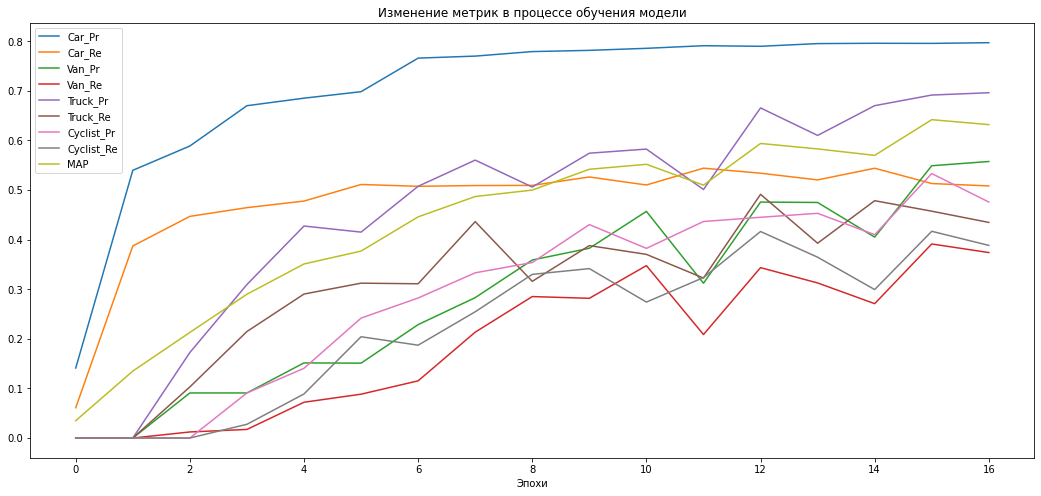

In [87]:
plt.figure(figsize=(18,8))
plt.plot(result_data[['Car_Pr', 'Car_Re', 'Van_Pr', 'Van_Re', 'Truck_Pr', 'Truck_Re', 'Cyclist_Pr', 'Cyclist_Re', 'MAP']])
plt.title('Изменение метрик в процессе обучения модели')
plt.xlabel('Эпохи')
plt.legend(['Car_Pr', 'Car_Re', 'Van_Pr', 'Van_Re', 'Truck_Pr', 'Truck_Re', 'Cyclist_Pr', 'Cyclist_Re', 'MAP'])
plt.show()

Пока снова дали доступ к GPU, попробую теперь переобучить модель обученную на СОСО на свой датасет. Хотя бы 10 эпох. И сравнить с предыдущим экспериментом.

In [30]:
result_data = pd.DataFrame(columns= ['Epoch', 'Car_Pr', 'Car_Re', 'Van_Pr', 'Van_Re', 
                                     'Truck_Pr', 'Truck_Re', 'Cyclist_Pr', 'Cyclist_Re', 'MAP'])
num_epochs = 10
for epoch in range(num_epochs):
    start = time.time()
    train_loss = train(train_loader, valid_loader)
    print(f"Epoch #{epoch} train_loss: {train_loss}")   
    APs, ARe, mAP = validate(valid_loader)
    save_model()
    print('model saved into: /content/fasterrcnn_resnet50_fpn.pth')
    result_data.loc[epoch] = [epoch, APs.get('Car'), ARe.get('Car'), APs.get('Van'), ARe.get('Van'), APs.get('Truck'), ARe.get('Truck'),
                               APs.get('Cyclist'), ARe.get('Cyclist'), mAP]
    #plot_eval(val_idx)
    end = time.time()
    print(f"Took {(end - start) / 60} minutes for epoch {epoch}")
    print()

Iteration #0 train_loss: 2.1223034858703613
Iteration #50 train_loss: 0.8436545729637146
Iteration #100 train_loss: 0.7480248212814331
Iteration #150 train_loss: 0.558888852596283
Iteration #200 train_loss: 0.5589836239814758
Iteration #250 train_loss: 0.6917626261711121
Iteration #300 train_loss: 0.4250752329826355
Epoch #0 train_loss: 0.02887667901813984
Precision :
{'Car': 0.6888019442558289, 'Cyclist': 0.0, 'Truck': 0.0, 'Van': 0.0}
Recall :
{'Car': 0.4758012592792511, 'Cyclist': 0.0, 'Truck': 0.0, 'Van': 0.0}

Mean Average Precision (mAP): 0.172
model saved into: /content/fasterrcnn_resnet50_fpn.pth
Took 16.890883592764535 minutes for epoch 0

Iteration #0 train_loss: 0.6070407629013062
Iteration #50 train_loss: 0.4226641058921814
Iteration #100 train_loss: 0.41042420268058777
Iteration #150 train_loss: 0.477901816368103
Iteration #200 train_loss: 0.4575943648815155
Iteration #250 train_loss: 0.383638471364975
Iteration #300 train_loss: 0.32984423637390137
Epoch #1 train_loss: 0.0

In [31]:
result_data

Epoch    Car_Pr    Car_Re  ...  Cyclist_Pr  Cyclist_Re       MAP
0    0.0  0.688802  0.475801  ...    0.000000    0.000000  0.172200
1    1.0  0.766723  0.511510  ...    0.289648    0.226536  0.370588
2    2.0  0.784553  0.549592  ...    0.358642    0.313816  0.408673
3    3.0  0.786788  0.513251  ...    0.496352    0.391563  0.494628
4    4.0  0.793048  0.525781  ...    0.447046    0.364437  0.515342
5    5.0  0.796690  0.520491  ...    0.470676    0.370567  0.548799
6    6.0  0.799787  0.534052  ...    0.541279    0.410291  0.584810
7    7.0  0.800951  0.540393  ...    0.540667    0.443756  0.589800
8    8.0  0.801844  0.530991  ...    0.570742    0.413304  0.622107
9    9.0  0.804467  0.530225  ...    0.564518    0.399053  0.643147

[10 rows x 10 columns]

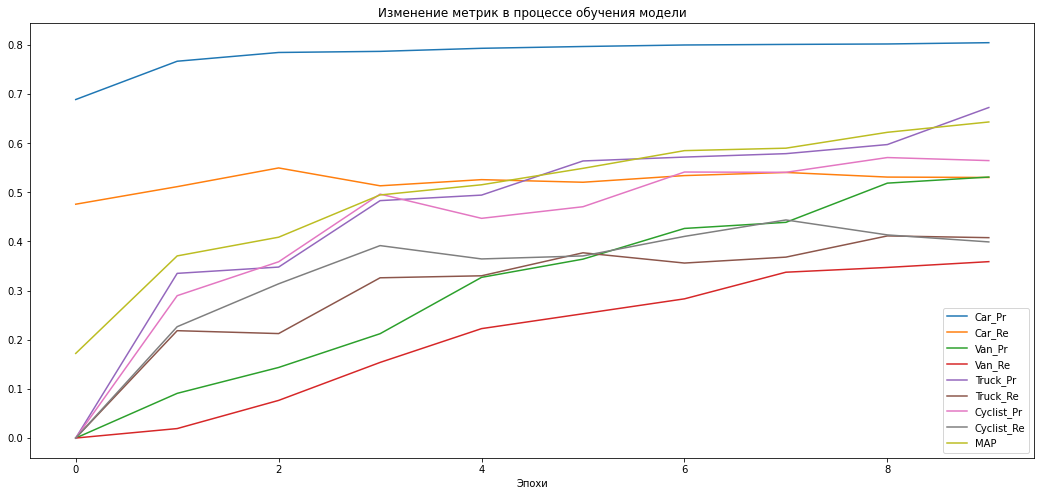

In [32]:
plt.figure(figsize=(18,8))
plt.plot(result_data[['Car_Pr', 'Car_Re', 'Van_Pr', 'Van_Re', 'Truck_Pr', 'Truck_Re', 'Cyclist_Pr', 'Cyclist_Re', 'MAP']])
plt.title('Изменение метрик в процессе обучения модели')
plt.xlabel('Эпохи')
plt.legend(['Car_Pr', 'Car_Re', 'Van_Pr', 'Van_Re', 'Truck_Pr', 'Truck_Re', 'Cyclist_Pr', 'Cyclist_Re', 'MAP'])
plt.show()

Несколько случайных примеров из валидационного датасета - оригинал/предсказание

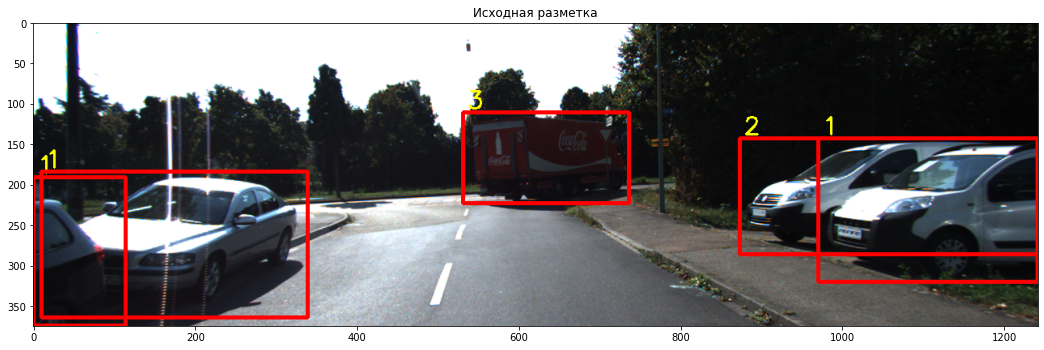

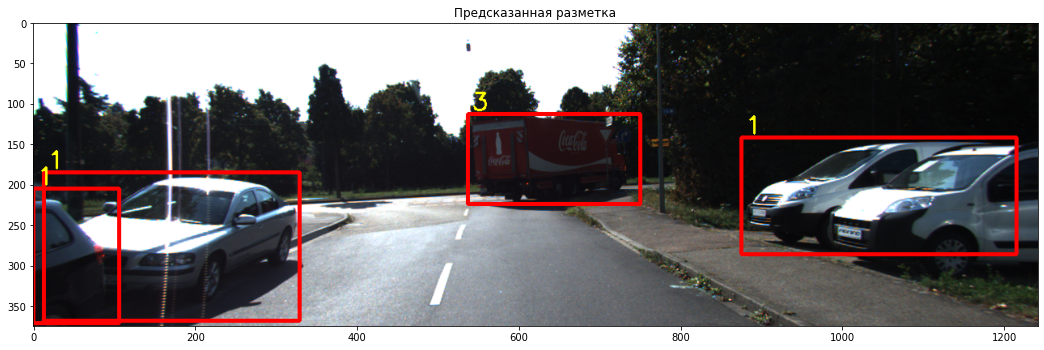

In [41]:
plot_eval(val_idx)

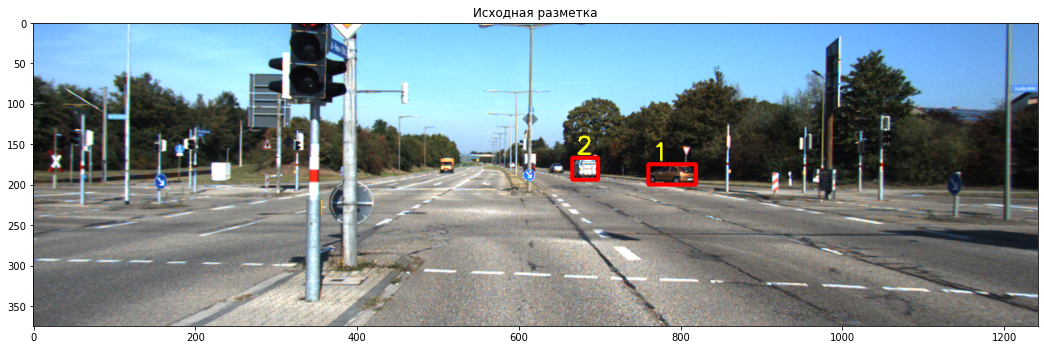

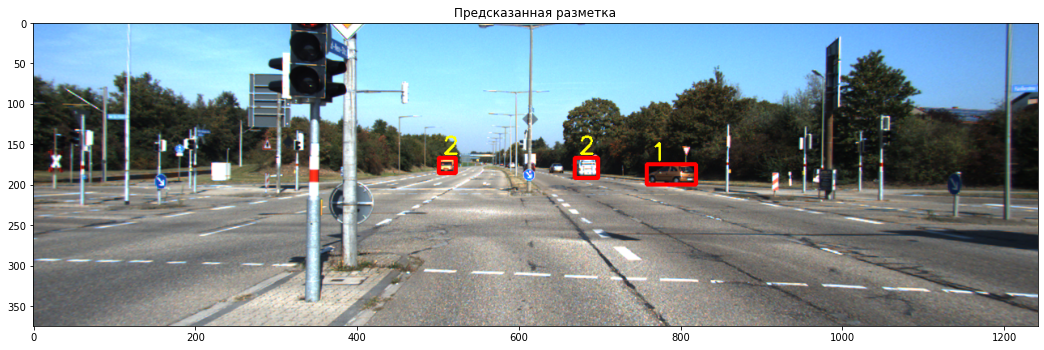

In [40]:
plot_eval(val_idx)

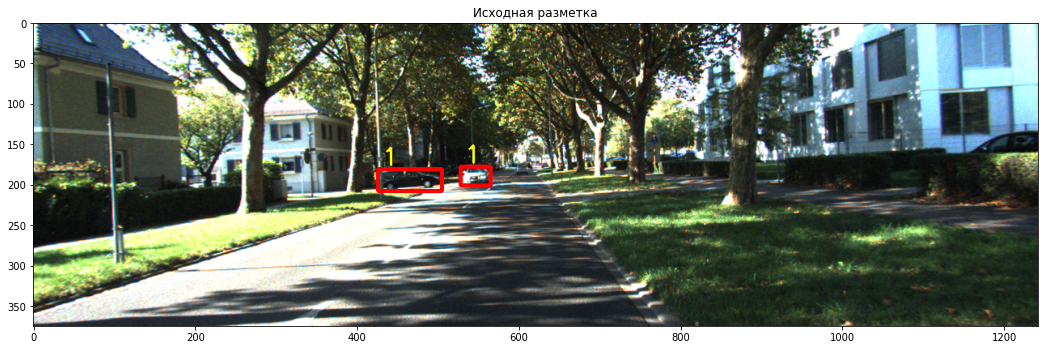

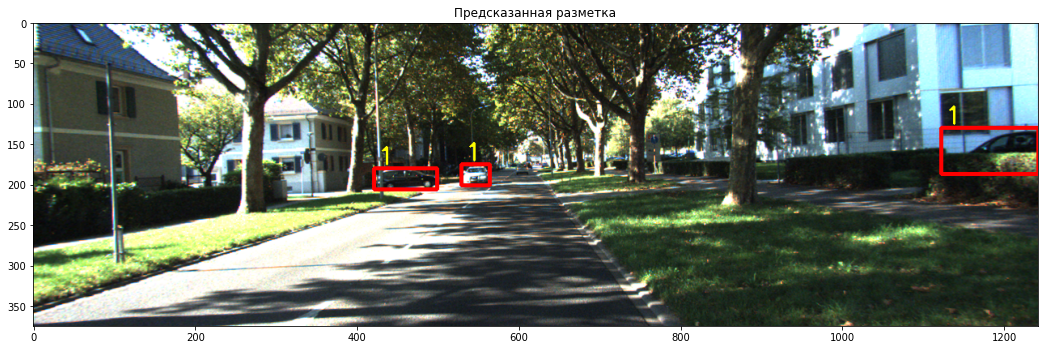

In [45]:
plot_eval(val_idx)

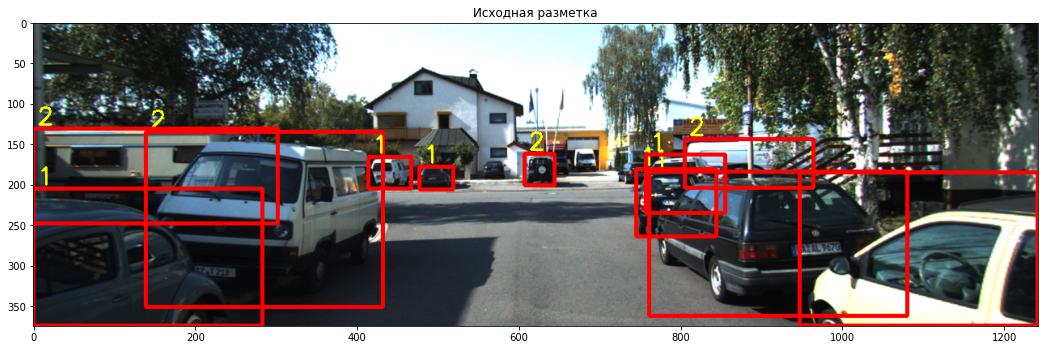

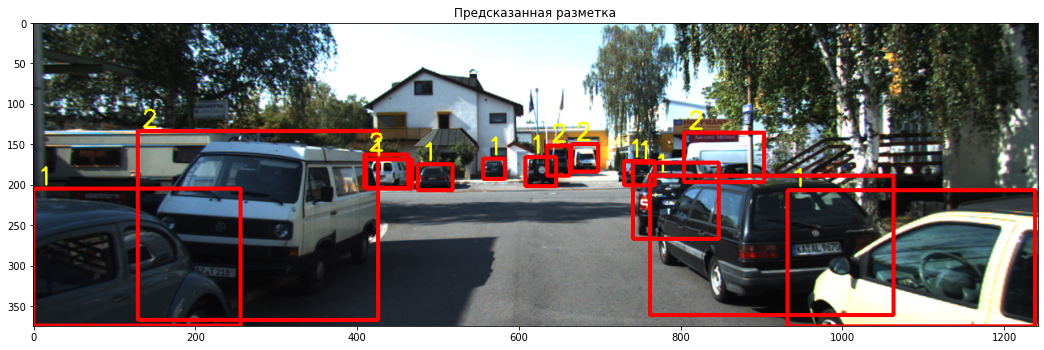

In [48]:
plot_eval(val_idx)

(734, 1100, 3)


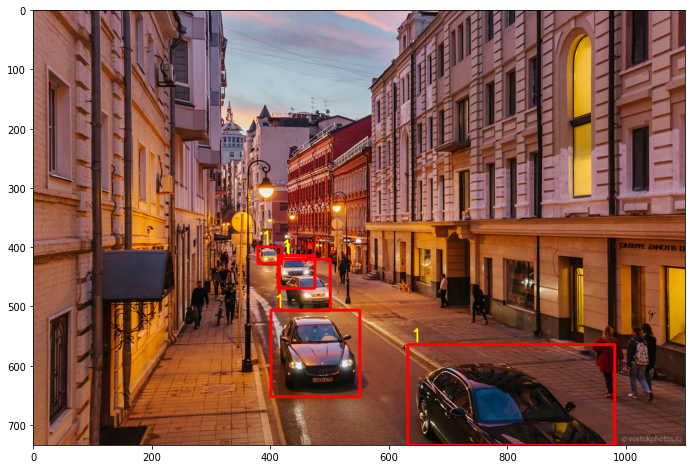

In [95]:
# предсказание на произвольной картинке
img_with_boxes = plot_img('/content/street.jpg', model) #, im_dataframe.boxes.loc[45])
print(img_with_boxes.shape)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

В качестве вывода о модели, могу сказать, что она неплохо обучается и хорошо предсказывает классы, особенно первый класс - автомобиль. Связано это в первую очередь с тем, что в обучающем датасете этот класс представлен очень объемно, гораздо больше других классов. На некоторых тестовых картинках новая модель предсказывала автомобили даже там, где они не были размечены на исходной и это видно на примерах выше. Все это конечно сказывается на результатах метрики, ведь мы сравниваем с исходными разметками. И на графике эта особенность датасета видна, когда по первому классу после первой эпохи сразу появляются показатели, а по остальным классам остаются нули. Кстати в сравнении с использованием непредобученной модели и предобученной модели на датасете СОСО так видно, что во втором случае дообучение модели идет гораздо быстрее.

Отвечая на пункт 7 задания могу сказать следующее. Изначально была идея сделать детектирование и классификацию автомобилей в соответствии с классами на платных участках дороги. Пару лет назад, проезжая на своей легковой машине через автоматический шлагбаум с транспордером я получил чек на оплату как за средний грузовик по высоте машины более 2-х метров. Дело в том, что у меня был бокс на крыше, а в автоматике стояло просто замер высоты (я так думаю). Поэтому пришлось писать письмо в службу поддержки для перерасчета тарифа. Отсюда появилась идея научить детектор определять тип машины не просто по датчикам высоты/количества осей и наличие прицепа, а и изначально по типу автомобиля. Но соответствующего датасета я не нашел и делать его самому просто физически не хватает времени. Поэтому задача была упрощена до простого определения типа автомобилей в соответствии с датасетом Kitti. То есть взята готовая архитектура и дообучена (или обучена с нуля - без разницы) на новом датасете.
В целом, если подготовить соответствующий датасет, то думаю, что можно будет и дообучить сеть под вышеуказанную задачу.

В процессе работы использовались следующие материалы:
1. Лекции и семинары DLSchool по задачам детекции
2. Туториал от [Pytorch](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)
3. Датасет [KITTI](https://www.kaggle.com/twaldo/kitti-object-detection) c Kaggle
4. Пример работы с датасетом KITTI на [Kaggle](https://www.kaggle.com/himasha0421/kitti-od)
5. [Road Pothole Detection with PyTorch Faster RCNN ResNet50](https://debuggercafe.com/road-pothole-detection-with-pytorch-faster-rcnn-resnet50/)
6. [mAP (mean Average Precision) for Object Detection](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)